In [1]:
% matplotlib notebook
import json
from utils import *

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from scipy.signal import wiener

import math
import scipy

from kalman_filtering import oneIterPowerKalmanFilter

from indicator_simulation_hypothesis_testing import *

/Users/stranot/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# # data_file = 'jsons/val_err_wo_lr_decay.json'
# # data_file = 'val_err.json'
# data_file = 'jsons/bs_32_val_err.json'
# # data_file = 'jsons/imagenet_dataset0.json'
# # data_file = 'jsons/cifar_all_lr_5e_2.json'
# # data_file = 'jsons/cifar_all_lr_1e_1.json'
# # data_file = 'jsons/cifar_all_lr_8e_2.json'
# with open(data_file) as f:
#     val_acc = json.load(f)
# val_err = 1 - np.array(val_acc)

# num_epochs_between_eval = 20
# min_delta = 5e-4
# patience = 15
# # steps = (np.arange(len(val_err)) + 1)*num_epochs_between_eval

# smooth_win_size = 55
# whole_smoothed_val_err = smooth_by_linear_filter(val_err, smooth_win_size)
# plt.figure()
# plt.plot((np.arange(len(val_err)) + 1)*num_epochs_between_eval, val_err)
# plt.plot((np.arange(len(whole_smoothed_val_err)) + 1)*num_epochs_between_eval, whole_smoothed_val_err)

# minEpoch = (np.argmin(whole_smoothed_val_err)+1)*num_epochs_between_eval
# print(minEpoch, np.min(whole_smoothed_val_err), len(whole_smoothed_val_err))
# earlyStoppingStep = early_stopping_step(val_err, min_delta, patience, smooth_win_size, num_epochs_between_eval )
# print(earlyStoppingStep, whole_smoothed_val_err[earlyStoppingStep//num_epochs_between_eval+1])

In [3]:
data_file = 'jsons/cifar_subset_train_summary_1.json'
with open(data_file) as f:
    dict_ = json.load(f)

eval_err = dict_['eval_err']
eval_epochs = dict_['eval_epochs']
train_err = np.array(dict_['train_err'])
train_epochs = np.array(dict_['train_epochs'])

plt.figure()
plt.plot(train_epochs, train_err)
plt.plot(eval_epochs, eval_err)


<IPython.core.display.Javascript object>

In [4]:
"""
Ignore the first part where evals are more intensive when getting the ground truch early stopping epoch
"""

# get the begin point after which the num_epochs_between_eval never changes anymore
e_ref = eval_epochs[0]
diff = eval_epochs[1] - e_ref
for i,e in enumerate(eval_epochs[1:]):
    if e - e_ref == diff:
        e_ref = e
    else:
        switch_point = i + 1
        switch_epoch = e
        break
# print(switch_point,switch_epoch, eval_epochs_[switch_point], eval_epochs_[switch_point-1], eval_epochs_[switch_point+1])

# delete the replicated values and the final one and the first one
eval_epochs.pop(switch_point)
eval_epochs.pop(-1)
eval_epochs.pop(0)
val_epochs = np.array(eval_epochs)
eval_err.pop(switch_point)
eval_err.pop(-1)
eval_err.pop(0)
val_err = np.array(eval_err)
switch_epoch = val_epochs[switch_point]

num_epochs_between_eval = val_epochs[switch_point+1] - switch_epoch
print(num_epochs_between_eval)
# print(num_epochs_between_eval)
# print(switch_point,switch_epoch, eval_epochs[switch_point], eval_epochs[switch_point-1], eval_epochs[switch_point+1])
min_delta = 3e-4
patience = 8
# steps = (np.arange(len(val_err)) + 1)*num_epochs_between_eval

smooth_win_size = 55

earlyStoppingStep = early_stopping_step(val_err[switch_point:], min_delta, patience, smooth_win_size, num_epochs_between_eval) + switch_epoch
print(earlyStoppingStep)
# print(eval_epochs, train_epochs)

20
9117


In [5]:
# # try other cases

# # data_file = 'jsons/val_err_wo_lr_decay.json'
# # data_file = 'jsons/val_err.json'
# data_file = 'jsons/bs_32_val_err.json'
# # data_file = 'jsons/imagenet_dataset0.json'
# # data_file = 'jsons/cifar_all_lr_5e_2.json'
# # data_file = 'jsons/cifar_all_lr_1e_1.json'
# # data_file = 'jsons/cifar_all_lr_8e_2.json'

# with open(data_file) as f:
#     val_acc = json.load(f)

# val_err = 1 - np.array(val_acc)
# num_epochs_between_eval = 20
# min_delta = 5e-4
# patience = 15
# # steps = (np.arange(len(val_err)) + 1)*num_epochs_between_eval

# smooth_win_size = 55
# whole_smoothed_val_err = smooth_by_linear_filter(val_err, smooth_win_size)
# plt.figure()
# plt.plot((np.arange(len(val_err)) + 1)*num_epochs_between_eval, val_err)
# plt.plot((np.arange(len(whole_smoothed_val_err)) + 1)*num_epochs_between_eval, whole_smoothed_val_err)

# minEpoch = (np.argmin(whole_smoothed_val_err)+1)*num_epochs_between_eval
# print(minEpoch, np.min(whole_smoothed_val_err), len(whole_smoothed_val_err))
# earlyStoppingStep = early_stopping_step(val_err, min_delta, patience, smooth_win_size, num_epochs_between_eval )
# print(earlyStoppingStep, whole_smoothed_val_err[earlyStoppingStep//num_epochs_between_eval+1])

# val_epochs = (np.arange(len(val_err)) + 1)*num_epochs_between_eval
# train_epochs = (np.arange(len(val_err)) + 1)*num_epochs_between_eval
# train_err = val_err


In [8]:
'''
common parametes
'''
pred_win_size = 1000 # large enough to include all the points curretly acquired
left_tail_size = 0
period = 20
start_point = 5
num_samples = 100
upper_limit = 2e5 # it's acually equivalent to setting no upper limit because 2e5 is larger enough
noise_est_win_size = 300
pure_regression_on_train_end=100
pure_regression_on_val_begin=150
pure_regression_on_regression_end=1000
pure_regression_on_original_begin=2000
on_train_pred_win_size=2000
on_train_period = 100

'''
result list
'''
all_preds = {}
all_errs = {}
all_steps = {}

In [9]:
'''
power_regression
'''
bnds = ((0, None), (None, 0))
inits = (1,0)
left_tail_size = 1000

# using unsmoothed data; estimate the noise by newest points
preds, coeffs, shifts, samples, smoothed_samples, CIs, _, step_intervals = powerRegressionIndicator(
                                    earlyStoppingStep,
                                    val_err, val_epochs, train_err, train_epochs,
                                    smooth_win_size,
                                     num_epochs_between_eval, 
                                     min_delta,
                                     patience,
                                    pred_win_size = pred_win_size,
                                    on_train_pred_win_size = on_train_pred_win_size,
                                    left_tail_size = left_tail_size,
                                    weights_type='linear',
                                    period = period,
                                    on_train_period=on_train_period,
                                    is_power_linear=False,
                                    bounds=bnds, inits=inits,
                                    start_point = start_point,
                                    num_samples=num_samples,
                                    upper_limit=upper_limit,
                                    online_smooth_win_size=1,
                                    noise_est_win_size = noise_est_win_size,
                                    pure_regression_on_train_end=pure_regression_on_train_end,
                                    pure_regression_on_val_begin=pure_regression_on_val_begin,
                                    pure_regression_on_regression_end=pure_regression_on_regression_end,
                                    pure_regression_on_original_begin=pure_regression_on_original_begin)

print(len(preds))
errs = CIs2errs(CIs)
all_preds['Power regression'] = preds
all_errs['Power regression'] = errs
all_steps['Power regression'] = shifts

Global Step: 6
True
Predicted Stopping epoch is 2028.0. a = 0, b = 0, d^2=0 on training curve
0.000521180131856095
Global Step: 106
False
Predicted Stopping epoch is 7548.8. a = 8.849450333436316, b = -0.6844786539463883, d^2=0 on training curve
0.0018537249295184548
Global Step: 206
False
Predicted Stopping epoch is 8721.6. a = 10.391727799085947, b = -0.6670684946890423, d^2=0 on training curve
0.002142512315939163
Global Step: 306
False
Predicted Stopping epoch is 10461.8. a = 11.882076394143885, b = -0.6774422242704673, d^2=0 on training curve
0.002985331565318825
Global Step: 406
False
Predicted Stopping epoch is 11422.8. a = 11.945328248412432, b = -0.6613392408044492, d^2=0 on training curve
0.0032762483528779906
Global Step: 505
False
Predicted Stopping epoch is 9892.0. a = 1.1197269611570375, b = -0.05429320985212527, d^2=0 on validation curve
0.0002813701183283961
Global Step: 605
False
Predicted Stopping epoch is 10305.0. a = 1.1323479244414396, b = -0.05646353638165636, d^2

In [10]:
'''
power + linear regression
'''
bnds = ((0, None), (None, 0), (None, None))
inits = (1,0,0)

# using unsmoothed data; estimate the noise by newest points
preds, coeffs, shifts, samples, smoothed_samples, CIs, _, step_intervals = powerRegressionIndicator(
                                    earlyStoppingStep,
                                    val_err, val_epochs, train_err, train_epochs,
                                    smooth_win_size,
                                     num_epochs_between_eval, 
                                     min_delta,
                                     patience,
                                    pred_win_size = pred_win_size,
                                    on_train_pred_win_size = on_train_pred_win_size,
                                    left_tail_size = left_tail_size,
                                    weights_type='linear',
                                    period = period,
                                    on_train_period=on_train_period,
                                    is_power_linear=True,
                                    bounds=bnds, inits=inits,
                                    start_point = start_point,
                                    num_samples=num_samples,
                                    upper_limit=upper_limit,
                                    online_smooth_win_size=1,
                                    noise_est_win_size = noise_est_win_size,
                                    pure_regression_on_train_end=pure_regression_on_train_end,
                                    pure_regression_on_val_begin=pure_regression_on_val_begin,
                                    pure_regression_on_regression_end=pure_regression_on_regression_end,
                                    pure_regression_on_original_begin=pure_regression_on_original_begin)
print(len(preds))
errs = CIs2errs(CIs)
all_preds['Power + linear regression'] = preds
all_errs['Power + linear regression'] = errs
all_steps['Power + linear regression'] = shifts

Global Step: 6
True
Predicted Stopping epoch is 1903.0. a = 0, b = 0, d^2=0 on training curve
0.0005211806618887509
Global Step: 106
False
Predicted Stopping epoch is 7775.0. a = 8.849450333436316, b = -0.6844786539463883, d^2=0 on training curve
0.001853952502785898
Global Step: 206
False
Predicted Stopping epoch is 8820.4. a = 10.391727799085947, b = -0.6670684946890423, d^2=0 on training curve
0.0021476327448030795
Global Step: 306
False
Predicted Stopping epoch is 10061.6. a = 11.882076394143885, b = -0.6774422242704673, d^2=0 on training curve
0.0030161195315160285
Global Step: 406
False
Predicted Stopping epoch is 10197.6. a = 11.945328248412432, b = -0.6613392408044492, d^2=0 on training curve
0.00335094165384606
Global Step: 505
False
Predicted Stopping epoch is 10609.6. a = 1.4849431615925317, b = -0.11752884627177156, d^2=0.00022589209384179298 on validation curve
0.0002813701183283961
Global Step: 605
False
Predicted Stopping epoch is 10300.8. a = 1.252512895831503, b = -0.0

In [11]:
# '''
# power_regression on smoothed eval_err
# '''
# bnds = ((0, None), (None, 0))
# inits = (1,0)
# left_tail_size = 1000

# # using unsmoothed data; estimate the noise by newest points
# preds, coeffs, shifts, samples, smoothed_samples, CIs, _, step_intervals = powerRegressionIndicator(
#                                     earlyStoppingStep,
#                                     val_err, val_epochs, train_err, train_epochs,
#                                     smooth_win_size,
#                                      num_epochs_between_eval, 
#                                      min_delta,
#                                      patience,
#                                     pred_win_size = pred_win_size,
#                                     on_train_pred_win_size = on_train_pred_win_size,
#                                     left_tail_size = left_tail_size,
#                                     weights_type='linear',
#                                     period = period,
#                                     on_train_period=on_train_period,
#                                     is_power_linear=False,
#                                     bounds=bnds, inits=inits,
#                                     start_point = start_point,
#                                     num_samples=num_samples,
#                                     upper_limit=upper_limit,
#                                     online_smooth_win_size=smooth_win_size,
#                                     noise_est_win_size = noise_est_win_size,
#                                     pure_regression_on_train_end=pure_regression_on_train_end,
#                                     pure_regression_on_val_begin=pure_regression_on_val_begin)

# print(len(preds))
# errs = CIs2errs(CIs)
# all_preds['Power regression + smoothed'] = preds
# all_errs['Power regression + smoothed'] = errs
# all_steps['Power regression + smoothed'] = shifts

In [12]:
# '''
# power + linear regression on smoothed eval_err
# '''
# bnds = ((0, None), (None, 0), (None, None))
# inits = (1,0,0)

# # using unsmoothed data; estimate the noise by newest points
# preds, coeffs, shifts, samples, smoothed_samples, CIs, _, step_intervals = powerRegressionIndicator(
#                                     earlyStoppingStep,
#                                     val_err, val_epochs, train_err, train_epochs,
#                                     smooth_win_size,
#                                      num_epochs_between_eval, 
#                                      min_delta,
#                                      patience,
#                                     pred_win_size = pred_win_size,
#                                     on_train_pred_win_size = on_train_pred_win_size,
#                                     left_tail_size = left_tail_size,
#                                     weights_type='linear',
#                                     period = period,
#                                     on_train_period=on_train_period,
#                                     is_power_linear=True,
#                                     bounds=bnds, inits=inits,
#                                     start_point = start_point,
#                                     num_samples=num_samples,
#                                     upper_limit=upper_limit,
#                                     online_smooth_win_size=smooth_win_size,
#                                     noise_est_win_size = noise_est_win_size,
#                                     pure_regression_on_train_end=pure_regression_on_train_end,
#                                     pure_regression_on_val_begin=pure_regression_on_val_begin)
# print(len(preds))
# errs = CIs2errs(CIs)
# all_preds['Power + linear regression + smoothed'] = preds
# all_errs['Power + linear regression + smoothed'] = errs
# all_steps['Power + linear regression + smoothed'] = shifts

In [13]:
# KF_start_point = 100
# report_period = 20
# init_d = 0
# var_ud = 1e-6

# preds, CIs, _,_,_,steps = KFIndicator(
#                             earlyStoppingStep,
#                             val_err,val_epochs,
#                             smooth_win_size,
#                              num_epochs_between_eval, 
#                              min_delta,
#                              patience,
#                             report_period,
#                             pred_win_size = pred_win_size,
#                             period = period,
#                             init_d = init_d,
#                             var_ud = var_ud,
#     start_point = KF_start_point,
# #                             start_point = start_point,
# #                             KF_start_point = KF_start_point,
#                             num_samples=num_samples,
#                             upper_limit=upper_limit,
#                             noise_est_win_size=noise_est_win_size)

# print(len(preds))
# errs = CIs2errs(CIs)
# all_preds['Kalman filtering'] = preds
# all_errs['Kalman filtering'] = errs
# all_steps['Kalman filtering'] = steps

<IPython.core.display.Javascript object>


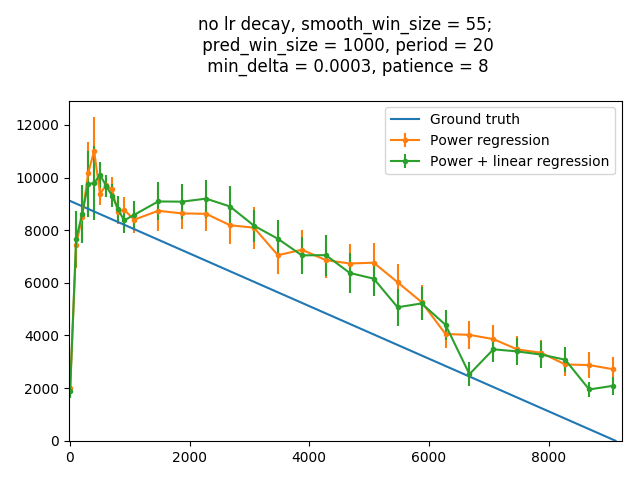

In [14]:
fig = plt.figure()
# ground truth
# x = (start_point+(np.arange(len(preds)))*report_period)*num_epochs_between_eval
x = np.arange(earlyStoppingStep)
plt.plot(x, earlyStoppingStep-x)
legend = ['Ground truth']

# three methods
for alg in all_preds:
    plt.errorbar(all_steps[alg], np.array(all_preds[alg])-np.array(all_steps[alg]), all_errs[alg], fmt='.-')
    legend.append(alg)
    
plt.xlim(-20,earlyStoppingStep+100)
plt.ylim(bottom=-20)
plt.legend(legend)
plt.title('no lr decay, smooth_win_size = {4};\n pred_win_size = {0}, period = {1}\n min_delta = {2}, patience = {3}\n '.
          format(pred_win_size, period, min_delta, patience, smooth_win_size))
fig.tight_layout()

# # save the image
# dir_ = '/Users/stranot/Desktop/resutls122318/cifar_subset_bs_32/'
# plt.savefig(dir_ + 'images/min_delta_{:.0e}_patience_{}.png'.format(min_delta, patience))

# # store the results
# for key in all_preds:
#     all_preds[key] = list(all_preds[key])
#     all_errs[key] = list(all_errs[key])
#     all_steps[key] = list(all_steps[key])
# output = {}
# output['all_preds'] = all_preds
# output['all_errs'] = all_errs
# output['all_steps'] = all_steps
# with open(dir_ + 'jsons/min_delta_{:.0e}_patience_{}.json'.format(min_delta, patience), 'w+') as f:
#     json.dump(output, f)

<IPython.core.display.Javascript object>


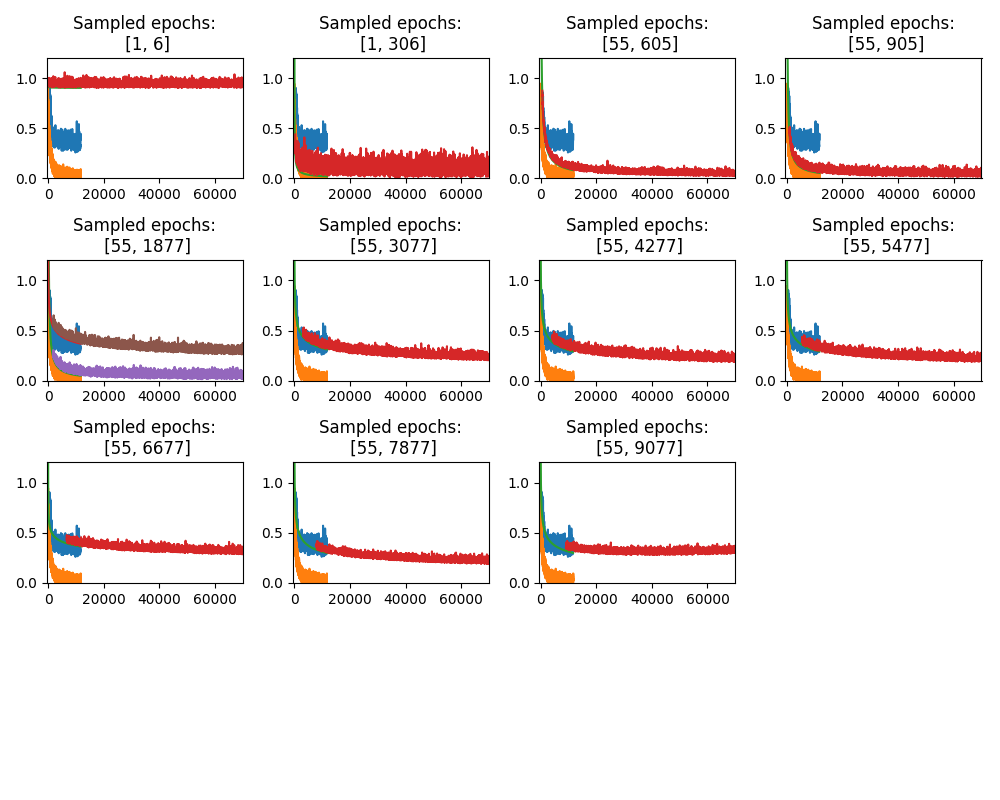

In [15]:
fig = plt.figure(figsize=[10, 8])
steps = (np.arange(len(val_err)) + 1)*num_epochs_between_eval
co = 0
step_size = 3
for i in range(0,len(coeffs),step_size):  
    co += 1
    ax = plt.subplot(4,4, co)
    ax.set_ylim(0, 1.2)
    ax.plot(val_epochs, val_err)
    ax.plot(train_epochs, train_err)
#     print(coeffs[i])
    for j, c in enumerate(coeffs[i]):
#         print(c)
        ax.plot(train_epochs,power_function(train_epochs, c[0], c[1]))
#     if coeffs[i][0] != None:
#         ax.plot(train_epochs,power_function(train_epochs, coeffs[i][0][0], coeffs[i][0][1]))
#     if coeffs[i][1] != None:
#         ax.plot(train_epochs,power_function(train_epochs, coeffs[i][1][0], coeffs[i][1][1]))
#     ax.plot(steps[:len(val_err)],power_function(steps[:len(val_err)], coeffs[i][0], coeffs[i][1]))
    
    e = step_intervals[i][-1]
    s = step_intervals[i][0]
    for j, s_ in enumerate(samples[i]):
        x = np.arange(1,len(s_)+1)*num_epochs_between_eval
        ax.plot(x+e,s_)
#     if len(samples[i][0]) != 0:
#         x = np.arange(1,len(samples[i][0])+1)*num_epochs_between_eval
#         ax.plot(x+e,samples[i][0])
#     if len(samples[i][1]) != 0:
#         x = np.arange(1,len(samples[i][1])+1)*num_epochs_between_eval
#         ax.plot(x+e,samples[i][1])
    ax.set_title('Sampled epochs:\n [{}, {}]'.format(s,e))
    ax.set_xlim(-500,70000)
    
fig.tight_layout()

In [16]:
# index = -1
# a = coeffs[index][0]
# b = coeffs[index][1]
# d = coeffs[index][2]
# steps = rastep_intervals[i][-1]
# step_intervals[i][0]